In [1]:
#Installing SHAP
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 3.5 MB/s eta 0:00:00


In [2]:
# Import our dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as skl
import tensorflow as tf
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler

# Importing the data

In [3]:
# Importing in the data into 2 seperate data frames from the excel file
xls = pd.ExcelFile('Plan A Task ML_final.xlsx')
commerce_og_df = pd.read_excel(xls, 'Department of Commerce')

In [4]:
# Checking the data imported correctly
commerce_og_df.head()

,RandomID,agency,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,POSTWT
0,171638000000,CM,2.0,2.0,4.0,4.0,3.0,3.0,3.0,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.337775
1,159842000000,CM,4.0,4.0,5.0,5.0,2.0,4.0,5.0,4,...,B,B,B,B,A,B,A,A,B,1.776877
2,160709000000,CM,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5,...,B,B,B,B,B,C,A,B,A,2.130467
3,135627000000,CM,4.0,2.0,3.0,3.0,4.0,2.0,4.0,4,...,B,B,A,B,A,C,B,B,A,2.060351
4,118318000000,CM,4.0,3.0,4.0,4.0,3.0,4.0,4.0,5,...,B,B,B,B,B,C,A,B,A,3.359444




---

# Data Exploration

In [5]:
# Creating a graph of all the value counts for each feature in the data

# Creating an empty data frame to store value counts
vc_df = pd.DataFrame()

# Creating a list of features we want to plot
columns_to_plot = ['Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q71', 'Q72', 'Q84', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89']

# Loop through the list and add counts to the vc_df
for column in columns_to_plot:
  value = commerce_og_df[column].value_counts()
  vc_df[column] = value

# Viewing data frame
vc_df.head()

,Q2,Q3,Q4,Q6,Q7,Q46,Q48,Q49,Q50,Q52,...,Q59,Q60,Q71,Q72,Q84,Q85,Q86,Q87,Q88,Q89
4.0,7857,9331,9723,9055,9982,7461,6358,5759,5629,5273,...,6579,7721,7756,7025,4443,8002,9470,7452,9554,8568
5.0,5513,6534,8090,4592,8539,9532,11346,12576,11129,12029,...,6191,5223,6062,7469,3216,4460,6000,5136,6371,10012
3.0,3734,2837,1700,3554,1495,1859,1382,1225,1977,2146,...,3461,4174,2744,2518,2103,4604,2727,4726,3156,1319
2.0,2359,1342,849,2239,534,816,826,522,979,661,...,1111,1625,917,525,428,2166,1272,1937,627,164
1.0,1208,674,377,1173,294,564,488,412,676,469,...,970,1236,621,462,327,961,673,971,443,161


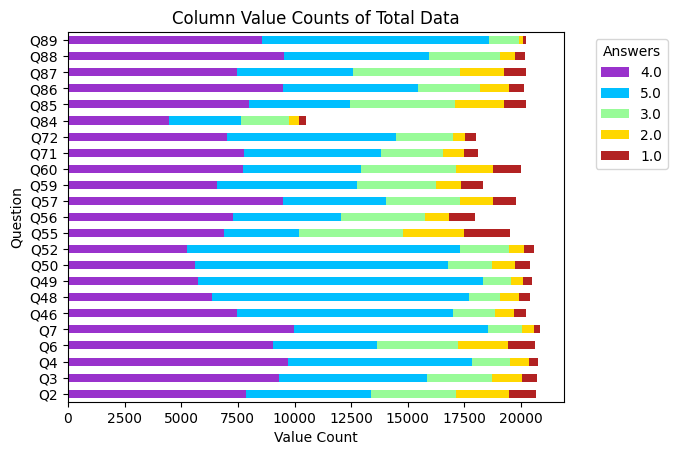

In [6]:
# Graphing the data to better visualize patterns
colors = [ 'darkorchid','deepskyblue','palegreen','gold','firebrick']
df_transposed = vc_df.T
df_transposed.plot(kind='barh', stacked = True, color = colors)
plt.title('Column Value Counts of Total Data')
plt.xlabel('Value Count')
plt.ylabel('Question')
plt.legend(title='Answers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('images/value_counts_overall_barh.png')
plt.show()

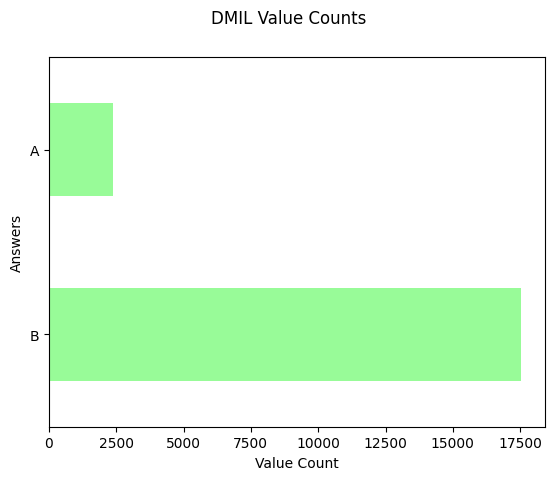

In [7]:
# Graphing the data to better visualize patterns
feature = 'DMIL'
colors = ['palegreen','palegreen','palegreen', 'firebrick', 'firebrick']  #,'gold' 'darkorchid','deepskyblue'
df_transposed = commerce_og_df[feature].value_counts()#.T
df_transposed.plot(kind='barh', stacked = True, color=colors)
plt.suptitle(f'{feature} Value Counts', fontsize=12)
plt.xlabel('Value Count')
plt.ylabel('Answers')
# plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

A    10065
B     9091
Name: DSEX, dtype: int64


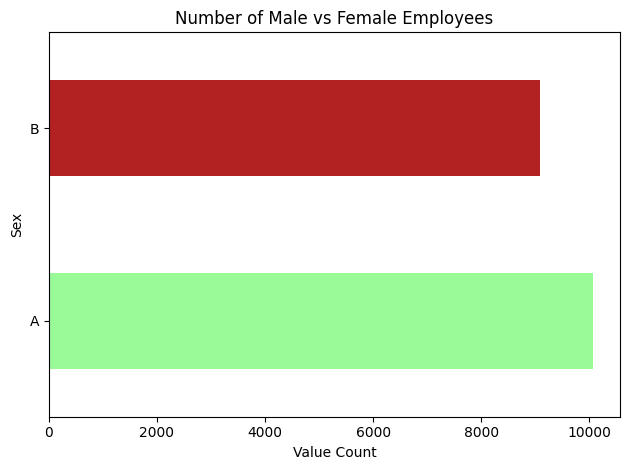

In [8]:
# Graphing to see how to weight of male to female is
colors = ['palegreen', 'firebrick']
df_transposed = commerce_og_df['DSEX'].value_counts()
df_transposed.plot(kind='barh', color=colors)
plt.title('Number of Male vs Female Employees')
plt.xlabel('Value Count')
plt.ylabel('Sex')
# plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
print(commerce_og_df['DSEX'].value_counts())
plt.show()

The number of female and male employees is pretty even, with 10,065 men and 9,091 women.

A    7435
B    1073
C     989
D     534
Name: DLEAVING, dtype: int64


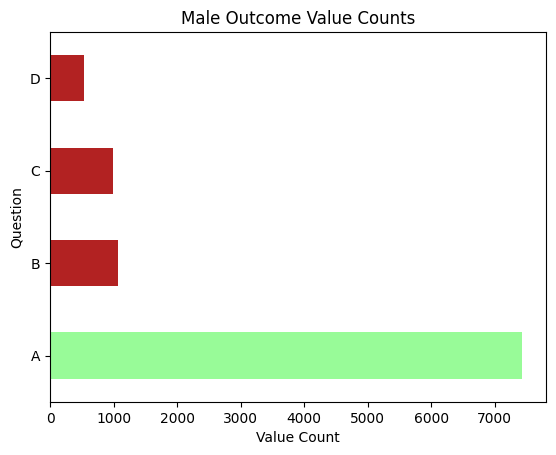

In [9]:
men = commerce_og_df[commerce_og_df['DSEX']=='A']
vc_men = men['DLEAVING'].value_counts()

colors = ['palegreen', 'firebrick', 'firebrick', 'firebrick']
df_transposed = vc_men
df_transposed.plot(kind='barh', color=colors)
plt.title('Male Outcome Value Counts')
plt.xlabel('Value Count')
plt.ylabel('Question')
# plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
print(vc_men)
plt.show()

About 25% of male employees said they would be leaving the company within the next year.

A    6618
C    1067
B    1032
D     318
Name: DLEAVING, dtype: int64


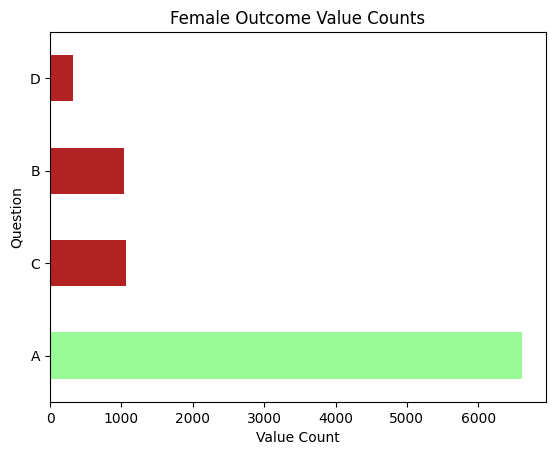

In [10]:
women = commerce_og_df[commerce_og_df['DSEX']=='B']
vc_women = women['DLEAVING'].value_counts()

colors = ['palegreen', 'firebrick', 'firebrick', 'firebrick']
df_transposed = vc_women
df_transposed.plot(kind='barh', color=colors)
plt.title('Female Outcome Value Counts')
plt.xlabel('Value Count')
plt.ylabel('Question')
# plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
print(vc_women)
plt.show()

About 25% of female employees said they would be leaving the company within the next year.

A    14568
B     2264
C     2195
D      914
Name: DLEAVING, dtype: int64


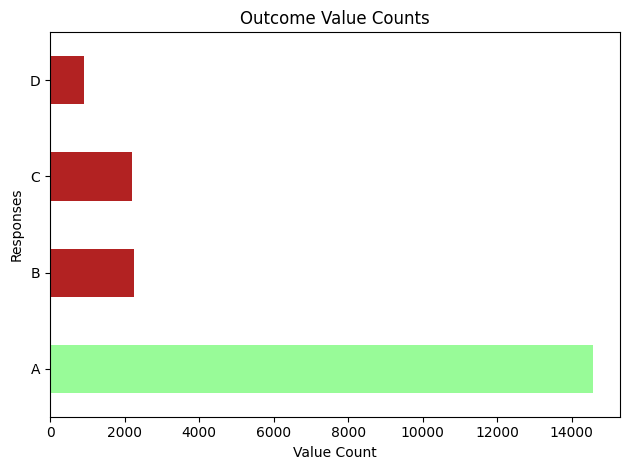

In [11]:
# Graphing the data to better understand the DLEAVING outcome feature.
outcome = commerce_og_df['DLEAVING'].value_counts()

colors = ['palegreen', 'firebrick', 'firebrick', 'firebrick']
df_transposed = commerce_og_df['DLEAVING'].value_counts()
df_transposed.plot(kind='barh', color=colors)
plt.title('Outcome Value Counts')
plt.xlabel('Value Count')
plt.ylabel('Responses')
# plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
print(outcome)
plt.show()

The negative outcomes make up about 26% of the data. This imbalance of data can effect the model. I chose to use imbalance learn in my seond model to see if it had any effect on the precitions.



---


# Data Cleaning

## Reducing the Data

I reduced the data from 116 columns to 31 columns initially. I reduce and combine some columns later.

In [12]:
# Removing columns not necessary for analysis
commerce_df = commerce_og_df[['Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q71', 'Q72', 'Q84', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DLEAVING']]

In [13]:
# Creating a list to reduce the number of times we have to type this out.
columns = {'Q2':'2_P_ENC_PROG', 'Q3':'3_P_ACC', 'Q4':'4_P_EXPECT', 'Q6':'6_P_TAL_USE', 'Q7': '7_P_WORK_TO_GOALS',
           'Q46': '46_SUP_SUPPORT', 'Q48': '48_SUP_LISTEN', 'Q49': '49_SUP_RESPECT', 'Q50': '50_SUP_TRUST',
           'Q52': '52_SUP_OVRAL', 'Q55' : '55_UPPER_MOTIVE', 'Q56': '56_UPPER_INTEG', 'Q57': '57_UPPER_GOALS',
           'Q59': '59_UPPER_OVRALL', 'Q60': '60_UPPER_RESPECT', 'Q71': '71_UPPER_DIVERS', 'Q72': '72_SUP_DIVERS',
           'Q84': '84_ACCESSABLE', 'Q85': '85_P_INSPIRE', 'Q86':'86_P_ACCOMPLISH', 'Q87': '87_P_ATTACHMENT',
           'Q88': '88_P_MISSION', 'Q89': '89_COMMON_GOOD'}

# Renaming  the columns to more descriptive names for quick analysis
commerce_df.rename(columns = columns, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# Checking to make sure the columns were renamed
commerce_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,88_P_MISSION,89_COMMON_GOOD,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DLEAVING
0,2.0,4.0,4.0,3.0,3.0,4,3.0,4.0,4.0,5.0,...,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,5.0,5.0,4.0,5.0,5,5.0,5.0,5.0,5.0,...,4.0,4.0,B,B,B,B,A,B,A,B
2,5.0,5.0,5.0,5.0,5.0,5,5.0,5.0,5.0,5.0,...,5.0,5.0,B,B,B,B,B,C,A,A
3,2.0,3.0,3.0,2.0,4.0,3,3.0,4.0,4.0,5.0,...,4.0,3.0,B,B,A,B,A,C,B,A
4,3.0,4.0,4.0,4.0,4.0,4,5.0,5.0,5.0,5.0,...,4.0,5.0,B,B,B,B,B,C,A,A


## Removing Rows with Missing Data

In this section, I removed any rows that did not have a response to DLEAVING. This survey is aimed at predicting whether or not an employee is planning on leaving the compnay. If the survey taker did not indicate this, their data is not helpful to this study. I also removed data rows that have more the 15% of the data in the row missing. This removed noise that would hinder the models later on.

In [15]:
# Remove data that has no response to whether or not the employee is leaving. This is the key peice of info the survey was trying to track, so if they did not answer this question, their data is not useful in this situation
commerce_df = commerce_df.loc[commerce_df['DLEAVING'].isin(['A' , 'B', 'C', 'D'])]
commerce_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,88_P_MISSION,89_COMMON_GOOD,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DLEAVING
1,4.0,5.0,5.0,4.0,5.0,5,5.0,5.0,5.0,5.0,...,4.0,4.0,B,B,B,B,A,B,A,B
2,5.0,5.0,5.0,5.0,5.0,5,5.0,5.0,5.0,5.0,...,5.0,5.0,B,B,B,B,B,C,A,A
3,2.0,3.0,3.0,2.0,4.0,3,3.0,4.0,4.0,5.0,...,4.0,3.0,B,B,A,B,A,C,B,A
4,3.0,4.0,4.0,4.0,4.0,4,5.0,5.0,5.0,5.0,...,4.0,5.0,B,B,B,B,B,C,A,A
5,4.0,5.0,5.0,4.0,5.0,5,5.0,5.0,5.0,5.0,...,5.0,5.0,B,B,B,B,B,C,A,A


In [16]:
# Checking to see the percentage of each feature/variable has a blank or null response.
missing_df = pd.DataFrame(commerce_df.isnull().mean()).reset_index()
missing_df

,index,0
0,2_P_ENC_PROG,0.015546
1,3_P_ACC,0.013690
2,4_P_EXPECT,0.012437
3,6_P_TAL_USE,0.018204
4,7_P_WORK_TO_GOALS,0.007372
5,46_SUP_SUPPORT,0.001705
6,48_SUP_LISTEN,0.011033
7,49_SUP_RESPECT,0.006569
8,50_SUP_TRUST,0.011183
9,52_SUP_OVRAL,0.002307


In [17]:
# Adding a column with the percentage of missing data for that row
commerce_df['row_missing_percent'] = commerce_df.isnull().mean(axis=1)
commerce_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,89_COMMON_GOOD,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DLEAVING,row_missing_percent
1,4.0,5.0,5.0,4.0,5.0,5,5.0,5.0,5.0,5.0,...,4.0,B,B,B,B,A,B,A,B,0.000000
2,5.0,5.0,5.0,5.0,5.0,5,5.0,5.0,5.0,5.0,...,5.0,B,B,B,B,B,C,A,A,0.000000
3,2.0,3.0,3.0,2.0,4.0,3,3.0,4.0,4.0,5.0,...,3.0,B,B,A,B,A,C,B,A,0.000000
4,3.0,4.0,4.0,4.0,4.0,4,5.0,5.0,5.0,5.0,...,5.0,B,B,B,B,B,C,A,A,0.032258
5,4.0,5.0,5.0,4.0,5.0,5,5.0,5.0,5.0,5.0,...,5.0,B,B,B,B,B,C,A,A,0.000000


In [18]:
# Removing any rows that have more than 10% of the data missing
cutpoint = .1
commerce_df = commerce_df.loc[commerce_df['row_missing_percent'] < cutpoint]

In [19]:
# Removing the row_missing_precent column as it is no longer necessary
commerce_df.drop(columns=['row_missing_percent'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
# Checking again to see how much of each feature/variable has a blank of null response after cleaning
missing_df = pd.DataFrame(commerce_df.isnull().mean()).reset_index()
missing_df

,index,0
0,2_P_ENC_PROG,0.013456
1,3_P_ACC,0.012137
2,4_P_EXPECT,0.010818
3,6_P_TAL_USE,0.016201
4,7_P_WORK_TO_GOALS,0.005752
5,46_SUP_SUPPORT,0.001003
6,48_SUP_LISTEN,0.008654
7,49_SUP_RESPECT,0.004802
8,50_SUP_TRUST,0.009024
9,52_SUP_OVRAL,0.001372




---


## Standardizing and Recoding the Data

In this section I standardized the data. After removing rows with more than 15% missing data, there were still rows with missing data. I replaced that missing data with an average of the feature for each missing data peice. I did this before I recoded question 84 and created dummy variables in order to not skew the average. I chose to replace both X and Y in question 84 to a 3 for simplicity. I also made sure that all my dtypes were correct for the next step of creating dummy variables.

In [21]:
# Creating a list of the column names
df_columns = commerce_df.columns
df_columns

Index(['2_P_ENC_PROG', '3_P_ACC', '4_P_EXPECT', '6_P_TAL_USE',
       '7_P_WORK_TO_GOALS', '46_SUP_SUPPORT', '48_SUP_LISTEN',
       '49_SUP_RESPECT', '50_SUP_TRUST', '52_SUP_OVRAL', '55_UPPER_MOTIVE',
       '56_UPPER_INTEG', '57_UPPER_GOALS', '59_UPPER_OVRALL',
       '60_UPPER_RESPECT', '71_UPPER_DIVERS', '72_SUP_DIVERS', '84_ACCESSABLE',
       '85_P_INSPIRE', '86_P_ACCOMPLISH', '87_P_ATTACHMENT', '88_P_MISSION',
       '89_COMMON_GOOD', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER',
       'DFEDTEN', 'DSEX', 'DLEAVING'],
      dtype='object')

In [22]:
# Replacing NaN values with the mode of that column. I chose to do this before replacing the X & Y choices to not skew the data towards the 3 value.
for impute_column in df_columns:
  commerce_df[impute_column].fillna(commerce_df[impute_column].mode()[0], inplace=True)

In [23]:
# Replacing all choices of X or Y, indicating "Do Not Know" or "No Basis to Judge", to 3, indicating "Neither Agree or Disagree".
commerce_df = commerce_df.replace(r'X', 3, regex=True)
commerce_df = commerce_df.replace(r'Y', 3, regex=True)

In [24]:
# Changing the type of numeric variables to 'int' to ensure all variables are treated properly
numeric_vars= ['2_P_ENC_PROG', '3_P_ACC', '4_P_EXPECT', '6_P_TAL_USE', '7_P_WORK_TO_GOALS',
       '46_SUP_SUPPORT', '48_SUP_LISTEN', '49_SUP_RESPECT', '50_SUP_TRUST', '52_SUP_OVRAL',
       '55_UPPER_MOTIVE', '56_UPPER_INTEG', '57_UPPER_GOALS', '59_UPPER_OVRALL',
       '60_UPPER_RESPECT', '71_UPPER_DIVERS', '72_SUP_DIVERS', '84_ACCESSABLE',
       '85_P_INSPIRE', '86_P_ACCOMPLISH', '87_P_ATTACHMENT', '88_P_MISSION', '89_COMMON_GOOD']

for num_column in numeric_vars:
  commerce_df[num_column]= commerce_df[num_column].astype(int)

In [25]:
# Checking the data type has changed
commerce_df.dtypes

2_P_ENC_PROG          int64
3_P_ACC               int64
4_P_EXPECT            int64
6_P_TAL_USE           int64
7_P_WORK_TO_GOALS     int64
46_SUP_SUPPORT        int64
48_SUP_LISTEN         int64
49_SUP_RESPECT        int64
50_SUP_TRUST          int64
52_SUP_OVRAL          int64
55_UPPER_MOTIVE       int64
56_UPPER_INTEG        int64
57_UPPER_GOALS        int64
59_UPPER_OVRALL       int64
60_UPPER_RESPECT      int64
71_UPPER_DIVERS       int64
72_SUP_DIVERS         int64
84_ACCESSABLE         int64
85_P_INSPIRE          int64
86_P_ACCOMPLISH       int64
87_P_ATTACHMENT       int64
88_P_MISSION          int64
89_COMMON_GOOD        int64
DRNO                 object
DHISP                object
DDIS                 object
DAGEGRP              object
DSUPER               object
DFEDTEN              object
DSEX                 object
DLEAVING             object
dtype: object

## Creating Dummy Variables

In this section, I created dummy variables for all the demographic data. Before doing this though, I manually recoded the outcome variable to create a binary outcome. I also dropped 1 of each of the dummy columns after they were created to reduce the noise in the model.

In [26]:
test_df = commerce_df
test_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,88_P_MISSION,89_COMMON_GOOD,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DLEAVING
1,4,5,5,4,5,5,5,5,5,5,...,4,4,B,B,B,B,A,B,A,B
2,5,5,5,5,5,5,5,5,5,5,...,5,5,B,B,B,B,B,C,A,A
3,2,3,3,2,4,3,3,4,4,5,...,4,3,B,B,A,B,A,C,B,A
4,3,4,4,4,4,4,5,5,5,5,...,4,5,B,B,B,B,B,C,A,A
5,4,5,5,4,5,5,5,5,5,5,...,5,5,B,B,B,B,B,C,A,A


In [27]:
# Recoding the outcome variable
test_df['DLEAVING'] = np.where(test_df['DLEAVING']=='A', 0,1)

In [28]:
# Getting dummies for all object variables, less the outcome variable.
commerce_dummy_df = pd.get_dummies(test_df)
commerce_dummy_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,DDIS_B,DAGEGRP_A,DAGEGRP_B,DSUPER_A,DSUPER_B,DFEDTEN_A,DFEDTEN_B,DFEDTEN_C,DSEX_A,DSEX_B
1,4,5,5,4,5,5,5,5,5,5,...,1,0,1,1,0,0,1,0,1,0
2,5,5,5,5,5,5,5,5,5,5,...,1,0,1,0,1,0,0,1,1,0
3,2,3,3,2,4,3,3,4,4,5,...,0,0,1,1,0,0,0,1,0,1
4,3,4,4,4,4,4,5,5,5,5,...,1,0,1,0,1,0,0,1,1,0
5,4,5,5,4,5,5,5,5,5,5,...,1,0,1,0,1,0,0,1,1,0


In [29]:
# Remove 1 dummy variable from each variable that was dummied.
commerce_dummy_df.drop(columns=['DRNO_B', 'DHISP_A', 'DDIS_A', 'DAGEGRP_A', 'DSUPER_A',
                                'DFEDTEN_A', 'DSEX_A'], inplace=True)



---


## Creating a correlation matrix

In this section, I created a correlation matrix to see if any features highly corrlated with others. I chose to combine questions 48, 49, 50, and 52. All of these features highly correlate to one another and would have added extra, unnecessary noise in the models. I also chose to combine questions 85, 86, and 87. The first two questions are very similar, the first asking about being inspired by the job and the next is a sense of accomplishment. These are very similar concepts and the questions have a correlation of 82%. The third question also has a high coorelation with the first two, being between 70 and 74 percent. The last columns I combined were 55, 56, and 60. These questions were all about the upper managment and had correlations around 78%.

<Axes: >

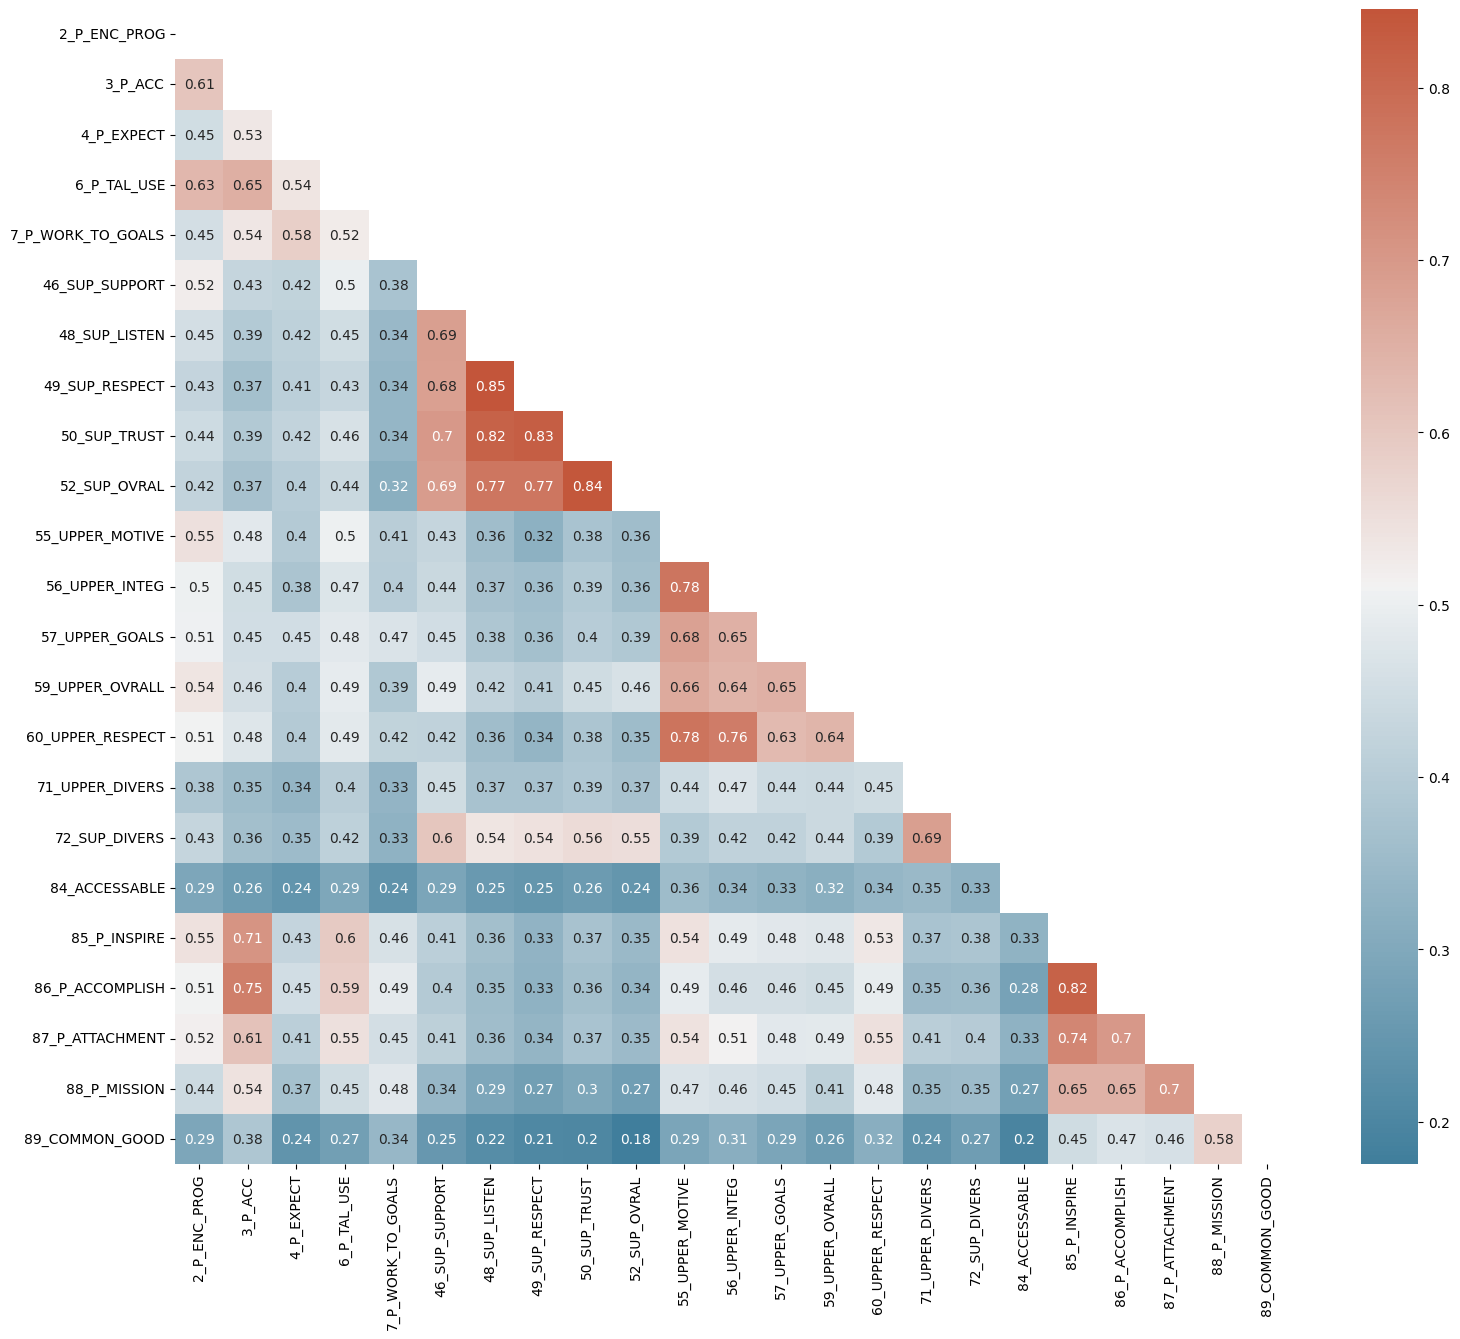

In [30]:
# Correlation between different feature variables. All dummied variables have been removed for this correlation matrix.

correlation_df = commerce_dummy_df[['2_P_ENC_PROG', '3_P_ACC', '4_P_EXPECT', '6_P_TAL_USE',
       '7_P_WORK_TO_GOALS', '46_SUP_SUPPORT', '48_SUP_LISTEN',
       '49_SUP_RESPECT', '50_SUP_TRUST', '52_SUP_OVRAL', '55_UPPER_MOTIVE',
       '56_UPPER_INTEG', '57_UPPER_GOALS', '59_UPPER_OVRALL',
       '60_UPPER_RESPECT', '71_UPPER_DIVERS', '72_SUP_DIVERS', '84_ACCESSABLE',
       '85_P_INSPIRE', '86_P_ACCOMPLISH', '87_P_ATTACHMENT', '88_P_MISSION',
       '89_COMMON_GOOD']].copy()

corr = correlation_df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(18, 15))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

plt.savefig('images/commerce_correlation_before')

<Axes: >

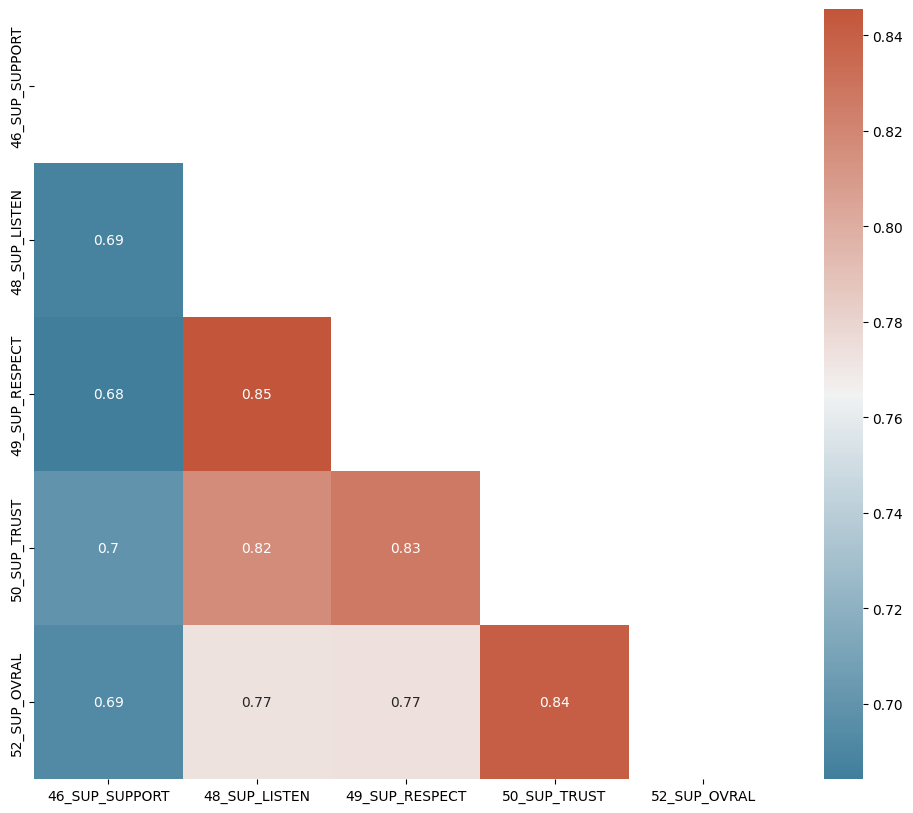

In [31]:
# Correlation between all supervisor variables. All dummied variables have been removed for this correlation matrix.

correlation_super_df = commerce_dummy_df[['46_SUP_SUPPORT', '48_SUP_LISTEN',
       '49_SUP_RESPECT', '50_SUP_TRUST', '52_SUP_OVRAL']].copy()

corr = correlation_super_df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [32]:
# Combining questions 48,49,50, and 52.
commerce_dummy_df['SUP_OVERALL']=(commerce_dummy_df['48_SUP_LISTEN'] + commerce_dummy_df['49_SUP_RESPECT'] + commerce_dummy_df['50_SUP_TRUST'] + commerce_dummy_df['52_SUP_OVRAL'])/4


<Axes: >

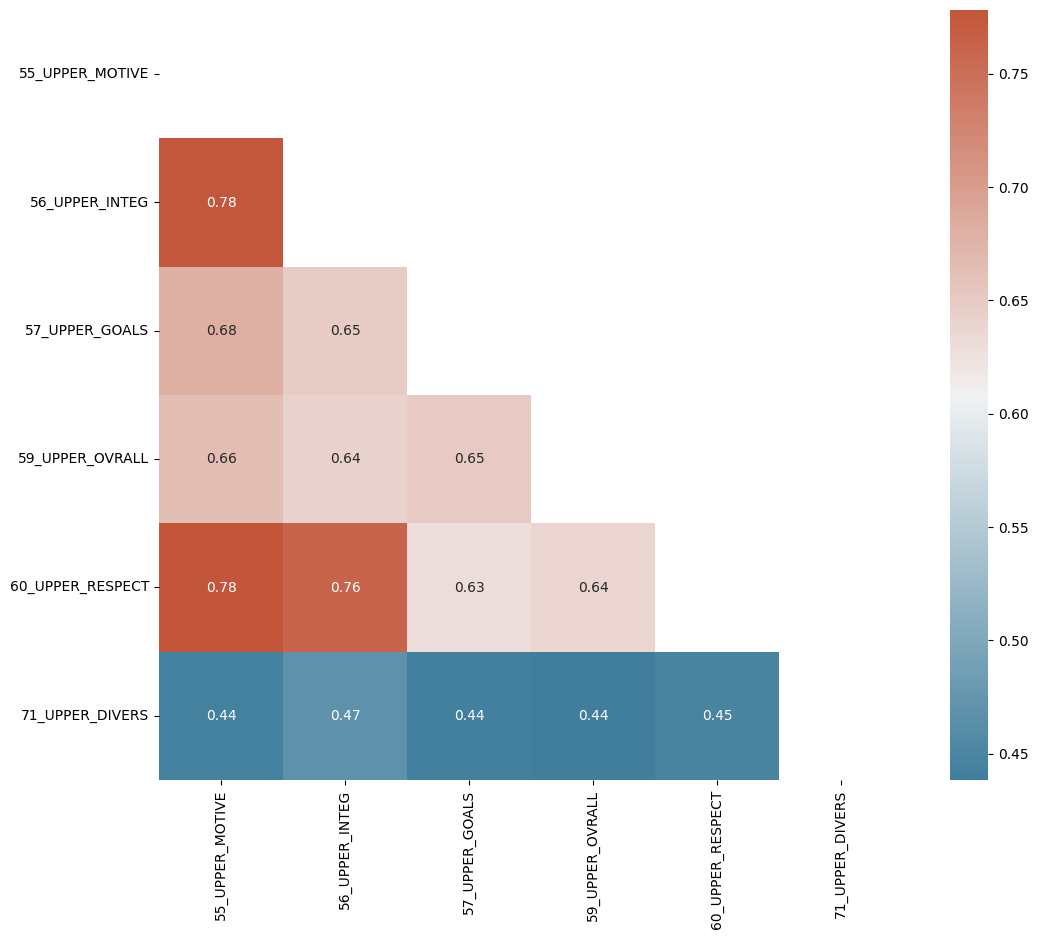

In [33]:
# Correlation between variables having to do with upper-management. All dummied variables have been removed for this correlation matrix.

correlation_upper_df = commerce_dummy_df[['55_UPPER_MOTIVE',
       '56_UPPER_INTEG', '57_UPPER_GOALS', '59_UPPER_OVRALL',
       '60_UPPER_RESPECT', '71_UPPER_DIVERS']].copy()

corr = correlation_upper_df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [34]:
# Combining questions 55, 56, and 60.
commerce_dummy_df['UPPER_OVERALL']=(commerce_dummy_df['55_UPPER_MOTIVE'] + commerce_dummy_df['56_UPPER_INTEG'] + commerce_dummy_df['60_UPPER_RESPECT'])/3

<Axes: >

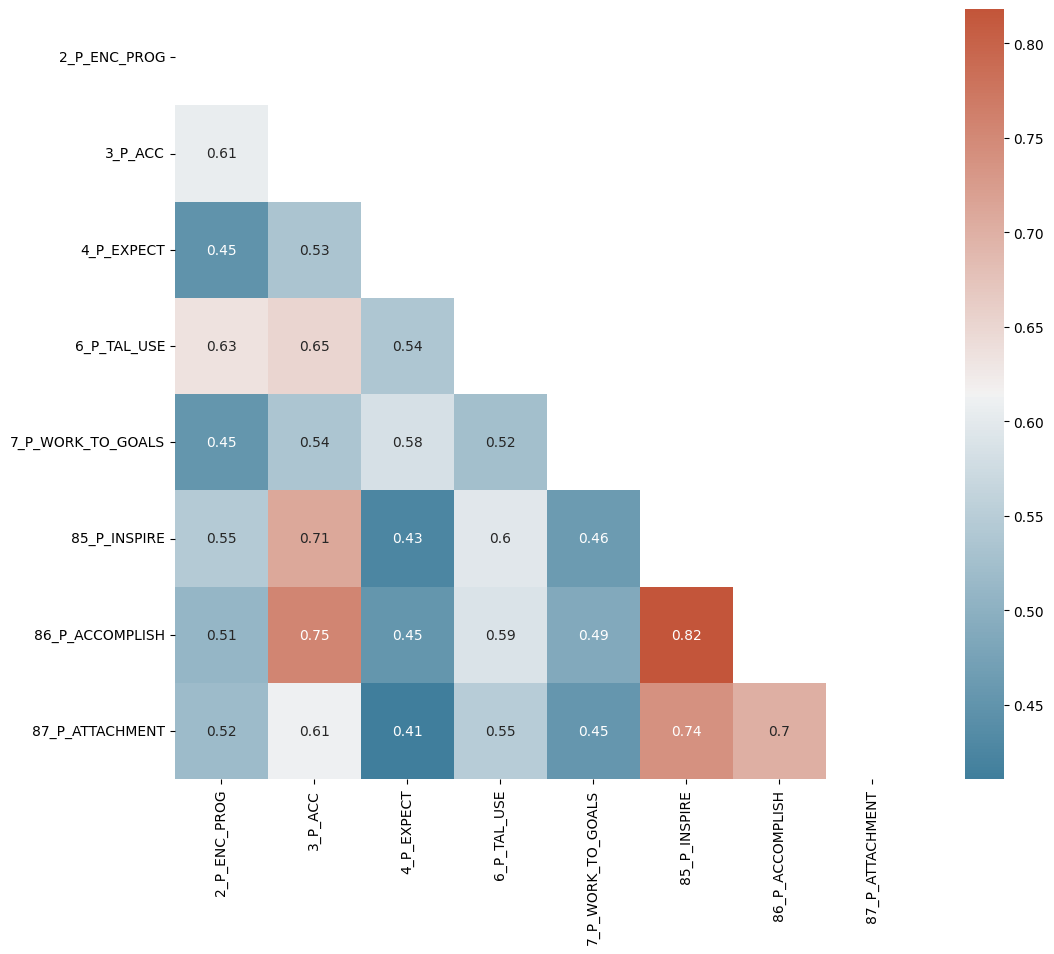

In [35]:
# Correlation between self-reflective variables. All dummied variables have been removed for this correlation matrix.

correlation_personal_df = commerce_dummy_df[['2_P_ENC_PROG', '3_P_ACC', '4_P_EXPECT', '6_P_TAL_USE',
       '7_P_WORK_TO_GOALS', '85_P_INSPIRE', '86_P_ACCOMPLISH', '87_P_ATTACHMENT']].copy()

corr = correlation_personal_df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

In [36]:
# Combining questions 85, 86, and 87
commerce_dummy_df['P_INSPIRED'] = (commerce_dummy_df['85_P_INSPIRE'] + commerce_dummy_df['86_P_ACCOMPLISH'] + commerce_dummy_df['87_P_ATTACHMENT'])/3

In [37]:
# Dropping the columns that were combined
commerce_dummy_df.drop(columns=['48_SUP_LISTEN','49_SUP_RESPECT', '50_SUP_TRUST', '52_SUP_OVRAL', '55_UPPER_MOTIVE',
       '56_UPPER_INTEG', '60_UPPER_RESPECT', '85_P_INSPIRE', '86_P_ACCOMPLISH', '87_P_ATTACHMENT'], inplace=True)

In [38]:
# Checking to make sure the columns were dropped and our new columns are there
commerce_dummy_df.columns

Index(['2_P_ENC_PROG', '3_P_ACC', '4_P_EXPECT', '6_P_TAL_USE',
       '7_P_WORK_TO_GOALS', '46_SUP_SUPPORT', '57_UPPER_GOALS',
       '59_UPPER_OVRALL', '71_UPPER_DIVERS', '72_SUP_DIVERS', '84_ACCESSABLE',
       '88_P_MISSION', '89_COMMON_GOOD', 'DLEAVING', 'DRNO_A', 'DRNO_C',
       'DRNO_D', 'DHISP_B', 'DDIS_B', 'DAGEGRP_B', 'DSUPER_B', 'DFEDTEN_B',
       'DFEDTEN_C', 'DSEX_B', 'SUP_OVERALL', 'UPPER_OVERALL', 'P_INSPIRED'],
      dtype='object')

<Axes: >

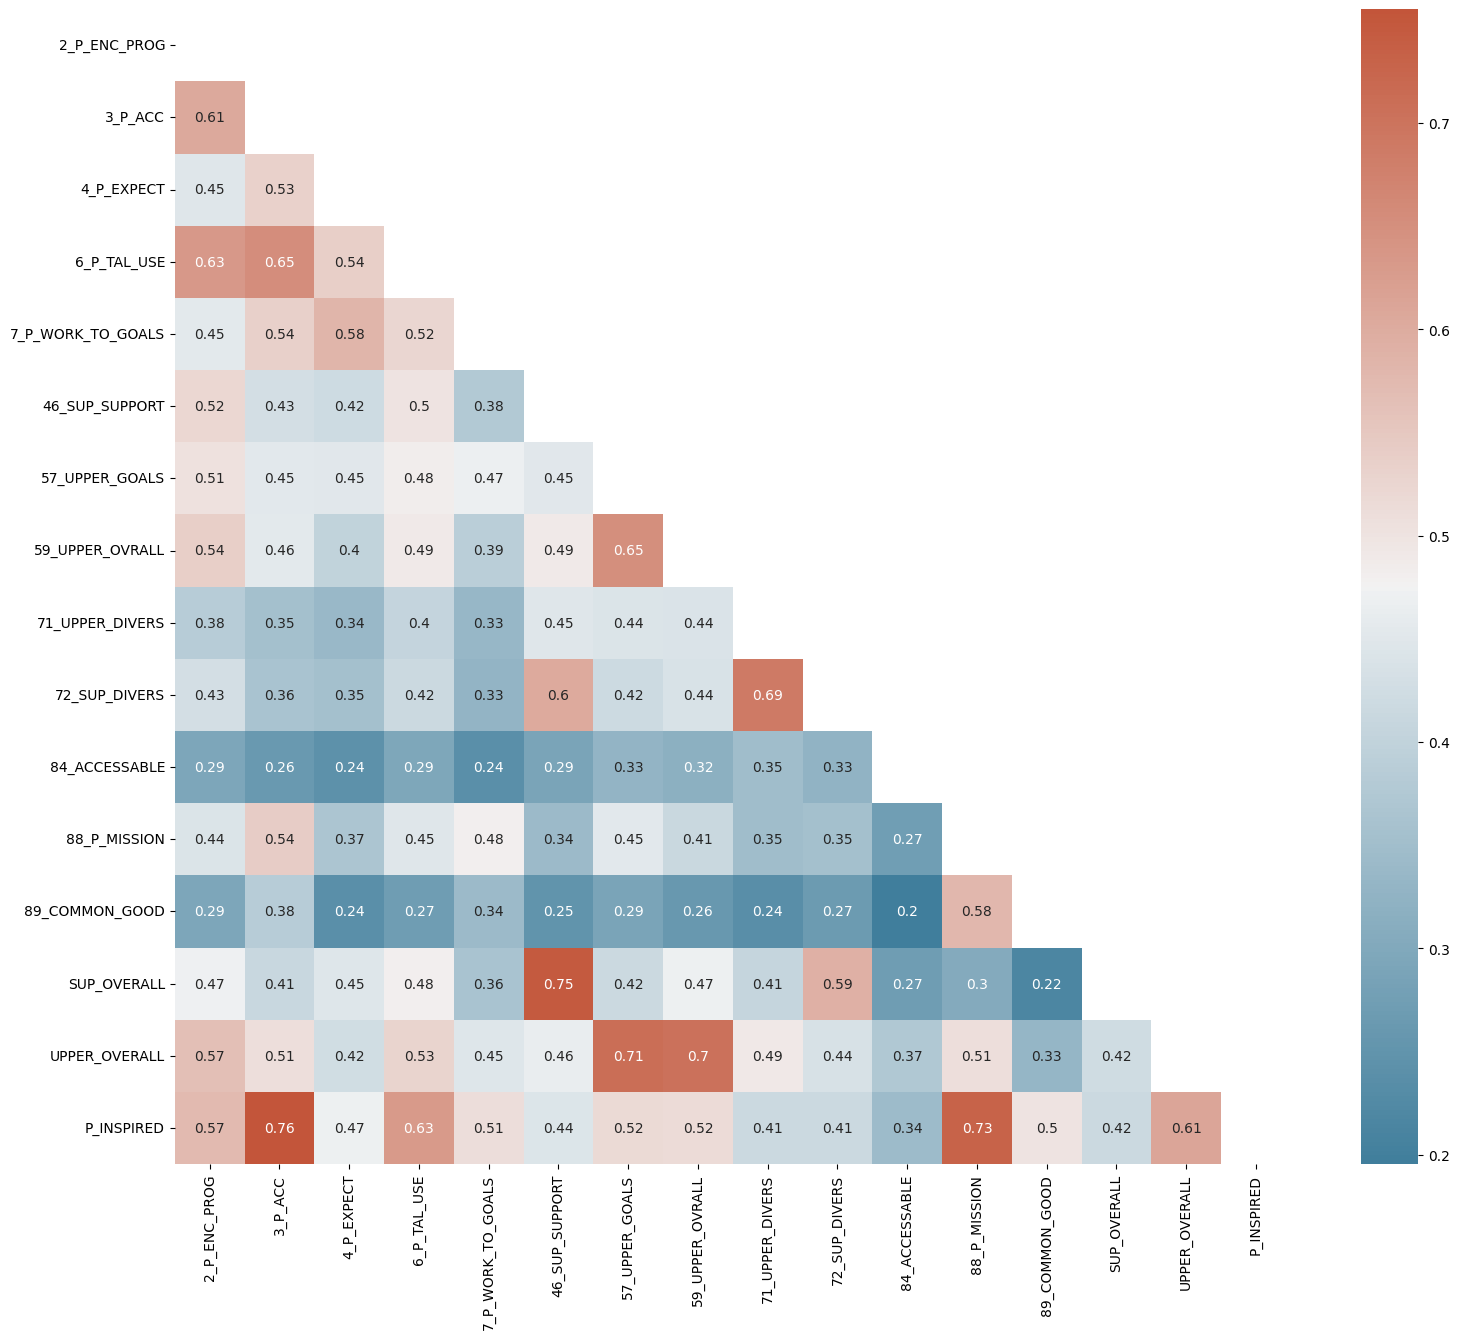

In [42]:
# Creating a second correlation matrix to see if the changes helped
# Correlation between different variables
correlation_df = commerce_dummy_df[['2_P_ENC_PROG', '3_P_ACC', '4_P_EXPECT', '6_P_TAL_USE',
       '7_P_WORK_TO_GOALS', '46_SUP_SUPPORT', '57_UPPER_GOALS', '59_UPPER_OVRALL',
       '71_UPPER_DIVERS', '72_SUP_DIVERS', '84_ACCESSABLE',
       '88_P_MISSION', '89_COMMON_GOOD','SUP_OVERALL', 'UPPER_OVERALL', 'P_INSPIRED']].copy()

corr = correlation_df.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(18, 15))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

plt.savefig('images/commerce_correlation_after')



---


# Logistic Regression

Seperate features and outcome variables, split data into training and test data, create a model, fit the model and analyze the outcome.

In [43]:
# Splitting the data into features and outcome variable
X = commerce_dummy_df.drop(columns=['DLEAVING'])
y = commerce_dummy_df[['DLEAVING']]

# Creating a max_iter variable
iters = 175

In [44]:
# Splitting the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y)

In [45]:
# Creating a Logistic Regression model
model_linreg = LogisticRegression(solver='lbfgs', random_state=2, penalty= None, max_iter=iters) # had to increase the iterations my model ran because the data "failed to converge" .

# Fit the model using training data
model_linreg.fit(X_train, np.ravel(y_train))

LogisticRegression(max_iter=175, penalty=None, random_state=2)

In [46]:
# Saving the predictions on the test data.
linreg_predictions = model_linreg.predict(X_test)

In [47]:
# Print the balanced_accuracy score of the model
score = round(balanced_accuracy_score(y_test, linreg_predictions), 3)
print(f"The balanced accuracy score for the first linear regression model is {score}.")

The balanced accuracy score for the first linear regression model is 0.628.


In [48]:
# Generating a confusion matrix for the model
cm = confusion_matrix(y_test, linreg_predictions)
cm_df = pd.DataFrame(cm, index=['Pos','Neg'], columns=['Pos','Neg'])
cm_df

,Pos,Neg
Pos,3300,191
Neg,860,387


In [49]:
# Print the classification report for the model
target_names = ['Not Leaving', 'Leaving']
print(classification_report(y_test, linreg_predictions, target_names=target_names))

              precision    recall  f1-score   support

 Not Leaving       0.79      0.95      0.86      3491
     Leaving       0.67      0.31      0.42      1247

    accuracy                           0.78      4738
   macro avg       0.73      0.63      0.64      4738
weighted avg       0.76      0.78      0.75      4738



The model has an accuracy rate of 62.8%. The prediction value for an employee not leaving the company is .86, while the prediction value for an employee leaving the company is .42. This means that the model is better at predicting an employee will stay with the company than if the employee will leave.

## SHAP Analysis

In [50]:
# Initiating the explainer and creating the shap_variables
explainer = shap.Explainer(model_linreg.predict, X_test)
shap_values = explainer(X_test)

PermutationExplainer explainer: 4739it [03:37, 21.16it/s]                          


In [51]:
# Viewing the shap_values
print(shap_values.values[0])

[ 0.00888889 -0.00277778 -0.01       -0.03333333 -0.00166667 -0.00166667
  0.00055556  0.         -0.02222222  0.01666667 -0.00388889  0.01055556
 -0.00388889 -0.00111111  0.00166667  0.          0.         -0.005
 -0.00111111  0.01444444  0.00055556  0.01       -0.00111111 -0.01111111
 -0.01333333 -0.06111111]


Absolute Mean Shap Value

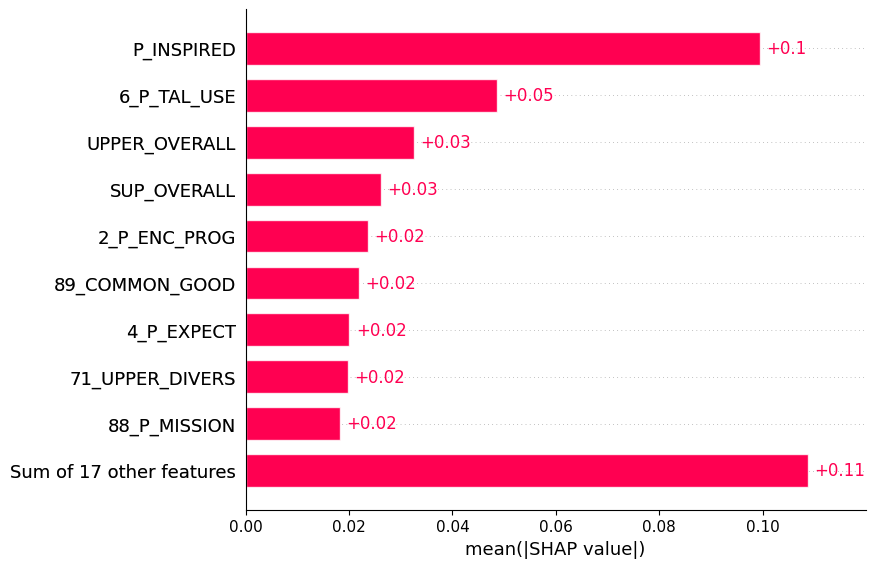

In [52]:
# Plot the mean shap value of the total data
shap.plots.bar(shap_values)

Summary Plot

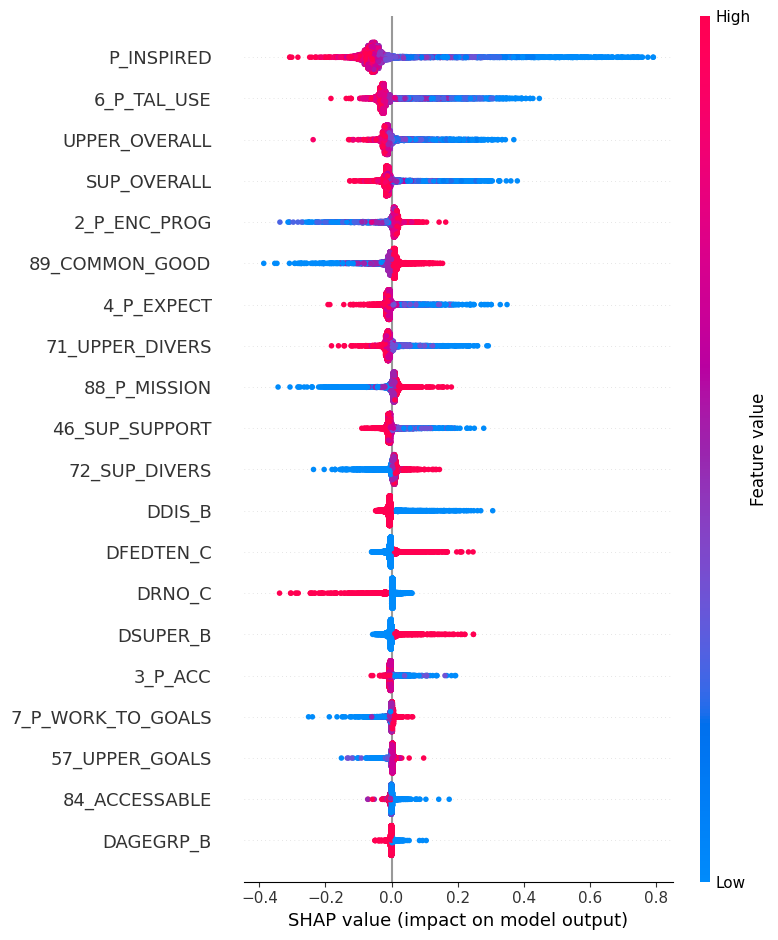

In [53]:
# Create a summary_plot to visualize the importance and effect of the features on the outcome
shap.summary_plot(shap_values)



---


## Logistic Regression Model Optimization

Around 26% of the data was for employees who indicated they would be leaving. This means the model has almost triple the data for an employee who is staying. I used RandomOverSampler to create a more balanced amount of negative and positive data. I also changed the solver.

In [54]:
#Using RandomOverSampler to help evn out the amount of positive and negative data we have
# Instantiate the random oversmapler model
ros_model = RandomOverSampler(random_state=2)

# Refit the original data to the ranomd_oversampler model
X_res, y_res = ros_model.fit_resample(X_train, y_train)

In [55]:
# Creating a second Logistic Regression model
model_2_linreg = LogisticRegression(solver='sag', random_state=2, penalty='l2', max_iter=175)

# Fit the model using training data
model_2_linreg.fit(X_res, np.ravel(y_res))

LogisticRegression(max_iter=175, random_state=2, solver='sag')

In [56]:
# Saving the predictions on the test data.
linreg_2_predictions = model_2_linreg.predict(X_test)

In [57]:
# Print the balanced_accuracy score of the model
score = round(balanced_accuracy_score(y_test, linreg_2_predictions), 3)
print(f"The balanced accuracy score for the second linear regression model is {score}.")

The balanced accuracy score for the second linear regression model is 0.683.


In [58]:
# Generating a confusion matrix for the model
cm_2 = confusion_matrix(y_test, linreg_2_predictions)
cm_2_df = pd.DataFrame(cm_2, index=['Pos','Neg'], columns=['Pos','Neg'])
cm_2_df

,Pos,Neg
Pos,2521,970
Neg,443,804


In [59]:
# Viewing the first confusion matrix to compare
cm_df

,Pos,Neg
Pos,3300,191
Neg,860,387


The second model classification report

In [60]:
# Second model with 'l2' penalty
# Print the classification report for the model
target_names = ['Not Leaving', 'Leaving']
print(classification_report(y_test, linreg_2_predictions, target_names=target_names))

              precision    recall  f1-score   support

 Not Leaving       0.85      0.72      0.78      3491
     Leaving       0.45      0.64      0.53      1247

    accuracy                           0.70      4738
   macro avg       0.65      0.68      0.66      4738
weighted avg       0.75      0.70      0.72      4738



The first model classification report

In [61]:
# First model with 'None' penatly
target_names = ['Not Leaving', 'Leaving']
print(classification_report(y_test, linreg_predictions, target_names=target_names))

              precision    recall  f1-score   support

 Not Leaving       0.79      0.95      0.86      3491
     Leaving       0.67      0.31      0.42      1247

    accuracy                           0.78      4738
   macro avg       0.73      0.63      0.64      4738
weighted avg       0.76      0.78      0.75      4738



The second model has a balanced accuracy rate of 68.3%. The prediction value for an employee not leaving the company is .78, while the prediction value for an employee leaving the company is .53. The model has gotten better at predicting that an employee will be leaving but has gotten worse at predicting they will stay. This model is actually better because while there may be a few more falsey predicted employees leaving, more actual employees who are leaving will be identified.



---


# Neural Network

We have 27 columns, so minus the outcome feature, there are 26 input features. I used the oversampled data from the previous model to ensure a better balance of data.

In [62]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_input_feat = 26
hidden_nodes_layer1 =  26 # the same as the input features.
hidden_nodes_layer2 = 50

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,  input_dim=num_input_feat, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [63]:
# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26)                702       
                                                                 
 dense_1 (Dense)             (None, 50)                1350      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2103 (8.21 KB)
Trainable params: 2103 (8.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [65]:
# Train the model
%time
fit_model = nn.fit(X_res,y_res,epochs=150)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Epoch 1/150
655/655 [==============================] - 2s 2ms/step - loss: 0.6329 - accuracy: 0.6435
Epoch 2/150
655/655 [==============================] - 2s 2ms/step - loss: 0.6042 - accuracy: 0.6760
Epoch 3/150
655/655 [==============================] - 2s 3ms/step - loss: 0.5998 - accuracy: 0.6766
Epoch 4/150
655/655 [==============================] - 2s 3ms/step - loss: 0.5963 - accuracy: 0.6832
Epoch 5/150
655/655 [==============================] - 1s 2ms/step - loss: 0.5937 - accuracy: 0.6863
Epoch 6/150
655/655 [==============================] - 1s 2ms/step - loss: 0.5934 - accuracy: 0.6855
Epoch 7/150
655/655 [==============================] - 1s 2ms/step - loss: 0.5915 - accuracy: 0.6866
Epoch 8/150
655/655 [==============================] - 1s 2ms/step - loss: 0.5884 - accuracy: 0.6879
Epoch 9/150
655/655 [==============================] - 1s 2ms/step - loss: 0.5879 - accuracy: 0.6867
Epoch 10/150
655/655 [=

In [66]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

149/149 - 0s - loss: 0.7086 - accuracy: 0.6862 - 343ms/epoch - 2ms/step
Loss: 0.7086281776428223, Accuracy: 0.6861544847488403


This model had an arruacy rate 75%, which is better than either of the logistic regression models previously. There is a loss value of .58, which means that there is a high number of errors.

## Neural Network Model Optimization

I added a hidden layer to the model with differnt amounts of nodes. I also reduced the number of epochs to try and reduce the chance of overfitting.

In [67]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_input_feat = 26
hidden_nodes_layer1 =  26
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 10

nn_2 = tf.keras.models.Sequential()

# First hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,  input_dim=num_input_feat, activation="relu"))

# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes_layer3,  activation="relu"))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [68]:
# Check the structure of the model
nn_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 26)                702       
                                                                 
 dense_4 (Dense)             (None, 30)                810       
                                                                 
 dense_5 (Dense)             (None, 10)                310       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1833 (7.16 KB)
Trainable params: 1833 (7.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
# Compile the model
nn_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [70]:
# Train the model
%time
fit_model = nn_2.fit(X_train,y_train,epochs=50)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 19.6 µs
Epoch 1/50
445/445 [==============================] - 3s 3ms/step - loss: 0.5413 - accuracy: 0.7435
Epoch 2/50
445/445 [==============================] - 1s 3ms/step - loss: 0.5135 - accuracy: 0.7631
Epoch 3/50
445/445 [==============================] - 1s 3ms/step - loss: 0.5065 - accuracy: 0.7672
Epoch 4/50
445/445 [==============================] - 1s 2ms/step - loss: 0.5037 - accuracy: 0.7682
Epoch 5/50
445/445 [==============================] - 1s 2ms/step - loss: 0.5030 - accuracy: 0.7689
Epoch 6/50
445/445 [==============================] - 1s 2ms/step - loss: 0.5002 - accuracy: 0.7699
Epoch 7/50
445/445 [==============================] - 1s 2ms/step - loss: 0.4993 - accuracy: 0.7704
Epoch 8/50
445/445 [==============================] - 1s 2ms/step - loss: 0.4979 - accuracy: 0.7701
Epoch 9/50
445/445 [==============================] - 1s 2ms/step - loss: 0.4973 - accuracy: 0.7731
Epoch 10/50
445/445 [=============

In [71]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_2.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

149/149 - 0s - loss: 0.5158 - accuracy: 0.7727 - 323ms/epoch - 2ms/step
Loss: 0.5158056616783142, Accuracy: 0.7726889252662659


 The network's final accuracy is .76 with a loss of .59. This model does not have a particularly good accuracy and a high number of errors. I would choose the second linear regression model over the neural networks.



---

# Production Model Testing

## Importing the Data

In [72]:
# Importing in the data into 2 seperate data frames from the excel file
labor_og_df = pd.read_excel(xls, 'Department of Labor')

In [73]:
# Checking the data imported correctly
labor_og_df.head()

,RandomID,agency,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DMIL,DLEAVING,POSTWT
0,114016000000,DL,4.0,3.0,5.0,5.0,4.0,4.0,5.0,4,...,B,B,B,B,B,B,A,B,A,1.430425
1,137377000000,DL,2.0,2.0,5.0,4.0,4.0,2.0,5.0,2,...,B,B,B,B,A,B,B,B,A,1.712627
2,131212000000,DL,5.0,4.0,4.0,4.0,2.0,4.0,5.0,5,...,B,B,A,B,A,A,A,A,A,1.532551
3,193260000000,DL,4.0,1.0,2.0,4.0,2.0,2.0,4.0,2,...,B,B,B,A,A,A,B,A,C,2.302167
4,197278000000,DL,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3,...,B,A,B,A,A,A,A,B,C,2.918573


## Data Cleaning

### Reducing, Removing, and Recoding Data

In [74]:
# Removing columns not necessary for analysis
labor_df = labor_og_df[['Q2', 'Q3', 'Q4', 'Q6', 'Q7', 'Q46', 'Q48', 'Q49', 'Q50', 'Q52', 'Q55', 'Q56', 'Q57', 'Q59', 'Q60', 'Q71', 'Q72', 'Q84', 'Q85', 'Q86', 'Q87', 'Q88', 'Q89', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER', 'DFEDTEN', 'DSEX', 'DLEAVING']]

In [75]:
# Creating a list to reduce the number of times we have to type this out.
columns = {'Q2':'2_P_ENC_PROG', 'Q3':'3_P_ACC', 'Q4':'4_P_EXPECT', 'Q6':'6_P_TAL_USE', 'Q7': '7_P_WORK_TO_GOALS',
           'Q46': '46_SUP_SUPPORT', 'Q48': '48_SUP_LISTEN', 'Q49': '49_SUP_RESPECT', 'Q50': '50_SUP_TRUST',
           'Q52': '52_SUP_OVRAL', 'Q55' : '55_UPPER_MOTIVE', 'Q56': '56_UPPER_INTEG', 'Q57': '57_UPPER_GOALS',
           'Q59': '59_UPPER_OVRALL', 'Q60': '60_UPPER_RESPECT', 'Q71': '71_UPPER_DIVERS', 'Q72': '72_SUP_DIVERS',
           'Q84': '84_ACCESSABLE', 'Q85': '85_P_INSPIRE', 'Q86':'86_P_ACCOMPLISH', 'Q87': '87_P_ATTACHMENT',
           'Q88': '88_P_MISSION', 'Q89': '89_COMMON_GOOD'}

# Renaming  the columns to more descriptive names for quick analysis
labor_df.rename(columns = columns, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [76]:
# Checking to make sure the columns were renamed
labor_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,88_P_MISSION,89_COMMON_GOOD,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DLEAVING
0,3.0,5.0,5.0,4.0,5.0,3,4.0,3.0,3.0,2.0,...,4.0,4.0,B,B,B,B,B,B,A,A
1,2.0,5.0,4.0,2.0,5.0,1,1.0,2.0,1.0,2.0,...,5.0,5.0,B,B,B,B,A,B,B,A
2,4.0,4.0,4.0,4.0,5.0,5,5.0,5.0,5.0,5.0,...,4.0,4.0,B,B,A,B,A,A,A,A
3,1.0,2.0,4.0,2.0,4.0,2,1.0,1.0,1.0,1.0,...,2.0,5.0,B,B,B,A,A,A,B,C
4,4.0,3.0,4.0,3.0,3.0,4,3.0,5.0,5.0,5.0,...,3.0,3.0,B,A,B,A,A,A,A,C


In [77]:
# Remove data that has no response to whether or not the employee is leaving. This is the key peice of info the survey was trying to track, so if they did not answer this question, their data is not useful in this situation
labor_df = labor_df.loc[labor_df['DLEAVING'].isin(['A' , 'B', 'C', 'D'])]
labor_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,88_P_MISSION,89_COMMON_GOOD,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DLEAVING
0,3.0,5.0,5.0,4.0,5.0,3,4.0,3.0,3.0,2.0,...,4.0,4.0,B,B,B,B,B,B,A,A
1,2.0,5.0,4.0,2.0,5.0,1,1.0,2.0,1.0,2.0,...,5.0,5.0,B,B,B,B,A,B,B,A
2,4.0,4.0,4.0,4.0,5.0,5,5.0,5.0,5.0,5.0,...,4.0,4.0,B,B,A,B,A,A,A,A
3,1.0,2.0,4.0,2.0,4.0,2,1.0,1.0,1.0,1.0,...,2.0,5.0,B,B,B,A,A,A,B,C
4,4.0,3.0,4.0,3.0,3.0,4,3.0,5.0,5.0,5.0,...,3.0,3.0,B,A,B,A,A,A,A,C


In [78]:
# Checking to see the percentage of each feature/variable has a blank or null response.
missing_df = pd.DataFrame(labor_df.isnull().mean()).reset_index()
missing_df

,index,0
0,2_P_ENC_PROG,0.013240
1,3_P_ACC,0.014237
2,4_P_EXPECT,0.012386
3,6_P_TAL_USE,0.017938
4,7_P_WORK_TO_GOALS,0.009254
5,46_SUP_SUPPORT,0.001139
6,48_SUP_LISTEN,0.008969
7,49_SUP_RESPECT,0.005837
8,50_SUP_TRUST,0.010535
9,52_SUP_OVRAL,0.001851


In [79]:
# Adding a column with the percentage of missing data for that row
labor_df['row_missing_percent'] = labor_df.isnull().mean(axis=1)
labor_df.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,89_COMMON_GOOD,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DLEAVING,row_missing_percent
0,3.0,5.0,5.0,4.0,5.0,3,4.0,3.0,3.0,2.0,...,4.0,B,B,B,B,B,B,A,A,0.0
1,2.0,5.0,4.0,2.0,5.0,1,1.0,2.0,1.0,2.0,...,5.0,B,B,B,B,A,B,B,A,0.0
2,4.0,4.0,4.0,4.0,5.0,5,5.0,5.0,5.0,5.0,...,4.0,B,B,A,B,A,A,A,A,0.0
3,1.0,2.0,4.0,2.0,4.0,2,1.0,1.0,1.0,1.0,...,5.0,B,B,B,A,A,A,B,C,0.0
4,4.0,3.0,4.0,3.0,3.0,4,3.0,5.0,5.0,5.0,...,3.0,B,A,B,A,A,A,A,C,0.0


In [80]:
# Removing any rows that have more than 10% of the data missing
cutpoint = .1
labor_df = labor_df.loc[labor_df['row_missing_percent'] < cutpoint]

In [81]:
# Removing the row_missing_precent column as it is no longer necessary
labor_df.drop(columns=['row_missing_percent'], inplace=True)

### Standardising and Recoding Data

In [82]:
# Creating a list of the column names
df_columns = labor_df.columns
df_columns

Index(['2_P_ENC_PROG', '3_P_ACC', '4_P_EXPECT', '6_P_TAL_USE',
       '7_P_WORK_TO_GOALS', '46_SUP_SUPPORT', '48_SUP_LISTEN',
       '49_SUP_RESPECT', '50_SUP_TRUST', '52_SUP_OVRAL', '55_UPPER_MOTIVE',
       '56_UPPER_INTEG', '57_UPPER_GOALS', '59_UPPER_OVRALL',
       '60_UPPER_RESPECT', '71_UPPER_DIVERS', '72_SUP_DIVERS', '84_ACCESSABLE',
       '85_P_INSPIRE', '86_P_ACCOMPLISH', '87_P_ATTACHMENT', '88_P_MISSION',
       '89_COMMON_GOOD', 'DRNO', 'DHISP', 'DDIS', 'DAGEGRP', 'DSUPER',
       'DFEDTEN', 'DSEX', 'DLEAVING'],
      dtype='object')

In [83]:
# Replacing NaN values with the mode of that column. I chose to do this before replacing the X & Y choices to not skew the data towards the 3 value.
for impute_column in df_columns:
  labor_df[impute_column].fillna(labor_df[impute_column].mode()[0], inplace=True)

In [84]:
# Replacing all choices of X or Y, indicating "Do Not Know" or "No Basis to Judge", to 3, indicating "Neither Agree or Disagree".
labor_df = labor_df.replace(r'X', 3, regex=True)
labor_df = labor_df.replace(r'Y', 3, regex=True)

In [85]:
# Changing the type of numeric variables to 'int' to ensure all variables are treated properly
numeric_vars= ['2_P_ENC_PROG', '3_P_ACC', '4_P_EXPECT', '6_P_TAL_USE', '7_P_WORK_TO_GOALS',
       '46_SUP_SUPPORT', '48_SUP_LISTEN', '49_SUP_RESPECT', '50_SUP_TRUST', '52_SUP_OVRAL',
       '55_UPPER_MOTIVE', '56_UPPER_INTEG', '57_UPPER_GOALS', '59_UPPER_OVRALL',
       '60_UPPER_RESPECT', '71_UPPER_DIVERS', '72_SUP_DIVERS', '84_ACCESSABLE',
       '85_P_INSPIRE', '86_P_ACCOMPLISH', '87_P_ATTACHMENT', '88_P_MISSION', '89_COMMON_GOOD']

for num_column in numeric_vars:
  labor_df[num_column]= labor_df[num_column].astype(int)

In [86]:
# Checking the data type has changed
labor_df.dtypes

2_P_ENC_PROG          int64
3_P_ACC               int64
4_P_EXPECT            int64
6_P_TAL_USE           int64
7_P_WORK_TO_GOALS     int64
46_SUP_SUPPORT        int64
48_SUP_LISTEN         int64
49_SUP_RESPECT        int64
50_SUP_TRUST          int64
52_SUP_OVRAL          int64
55_UPPER_MOTIVE       int64
56_UPPER_INTEG        int64
57_UPPER_GOALS        int64
59_UPPER_OVRALL       int64
60_UPPER_RESPECT      int64
71_UPPER_DIVERS       int64
72_SUP_DIVERS         int64
84_ACCESSABLE         int64
85_P_INSPIRE          int64
86_P_ACCOMPLISH       int64
87_P_ATTACHMENT       int64
88_P_MISSION          int64
89_COMMON_GOOD        int64
DRNO                 object
DHISP                object
DDIS                 object
DAGEGRP              object
DSUPER               object
DFEDTEN              object
DSEX                 object
DLEAVING             object
dtype: object

### Creating Dummy Variables

In [87]:
test_df = labor_df
test_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,88_P_MISSION,89_COMMON_GOOD,DRNO,DHISP,DDIS,DAGEGRP,DSUPER,DFEDTEN,DSEX,DLEAVING
0,3,5,5,4,5,3,4,3,3,2,...,4,4,B,B,B,B,B,B,A,A
1,2,5,4,2,5,1,1,2,1,2,...,5,5,B,B,B,B,A,B,B,A
2,4,4,4,4,5,5,5,5,5,5,...,4,4,B,B,A,B,A,A,A,A
3,1,2,4,2,4,2,1,1,1,1,...,2,5,B,B,B,A,A,A,B,C
4,4,3,4,3,3,4,3,5,5,5,...,3,3,B,A,B,A,A,A,A,C


In [88]:
# Recoding the outcome variable
test_df['DLEAVING'] = np.where(test_df['DLEAVING']=='A', 0,1)

In [89]:
labor_dummy_df = pd.get_dummies(test_df)
labor_dummy_df.head()

,2_P_ENC_PROG,3_P_ACC,4_P_EXPECT,6_P_TAL_USE,7_P_WORK_TO_GOALS,46_SUP_SUPPORT,48_SUP_LISTEN,49_SUP_RESPECT,50_SUP_TRUST,52_SUP_OVRAL,...,DDIS_B,DAGEGRP_A,DAGEGRP_B,DSUPER_A,DSUPER_B,DFEDTEN_A,DFEDTEN_B,DFEDTEN_C,DSEX_A,DSEX_B
0,3,5,5,4,5,3,4,3,3,2,...,1,0,1,0,1,0,1,0,1,0
1,2,5,4,2,5,1,1,2,1,2,...,1,0,1,1,0,0,1,0,0,1
2,4,4,4,4,5,5,5,5,5,5,...,0,0,1,1,0,1,0,0,1,0
3,1,2,4,2,4,2,1,1,1,1,...,1,1,0,1,0,1,0,0,0,1
4,4,3,4,3,3,4,3,5,5,5,...,1,1,0,1,0,1,0,0,1,0


In [90]:
# Remove 1 dummy variable from each variable that was dummied.
labor_dummy_df.drop(columns=['DRNO_B', 'DHISP_A', 'DDIS_A', 'DAGEGRP_A', 'DSUPER_A',
                                'DFEDTEN_A', 'DSEX_A'], inplace=True)

In [91]:
# Combining questions 48,49,50, and 52.
labor_dummy_df['SUP_OVERALL']=(labor_dummy_df['48_SUP_LISTEN'] + labor_dummy_df['49_SUP_RESPECT'] + labor_dummy_df['50_SUP_TRUST'] + labor_dummy_df['52_SUP_OVRAL'])/4

In [92]:
# Combining questions 55, 56, and 60.
labor_dummy_df['UPPER_OVERALL']=(labor_dummy_df['55_UPPER_MOTIVE'] + labor_dummy_df['56_UPPER_INTEG'] + labor_dummy_df['60_UPPER_RESPECT'])/3

In [93]:
# Combining questions 85, 86, and 87
labor_dummy_df['P_INSPIRED'] = (labor_dummy_df['85_P_INSPIRE'] + labor_dummy_df['86_P_ACCOMPLISH'] + labor_dummy_df['87_P_ATTACHMENT'])/3

In [95]:
# Dropping the columns that were combined
labor_dummy_df.drop(columns=['48_SUP_LISTEN','49_SUP_RESPECT', '50_SUP_TRUST', '52_SUP_OVRAL', '55_UPPER_MOTIVE', '56_UPPER_INTEG', '60_UPPER_RESPECT', '85_P_INSPIRE', '86_P_ACCOMPLISH', '87_P_ATTACHMENT'], inplace=True)

## Running Linear Regression for Department of Labor Predictions

In [96]:
# Dividing the data between outcome and featrures
labor_X = labor_dummy_df.drop(columns=['DLEAVING'])
labor_y = labor_dummy_df[['DLEAVING']]

In [97]:
# Saving the predictions on the test data.
linreg_labor_predictions = model_2_linreg.predict(labor_X)

In [98]:
# Print the balanced accuracy score
score = round(balanced_accuracy_score(labor_y, linreg_labor_predictions), 3)
print(f"The balanced accuracy score for the second linear regression model is {score}.")

The balanced accuracy score for the second linear regression model is 0.697.


In [99]:
# Print the classifcation report
target_names = ['Not Leaving', 'Leaving']
print(classification_report(labor_y, linreg_labor_predictions, target_names=target_names))

              precision    recall  f1-score   support

 Not Leaving       0.83      0.73      0.78      4422
     Leaving       0.53      0.66      0.59      2011

    accuracy                           0.71      6433
   macro avg       0.68      0.70      0.68      6433
weighted avg       0.73      0.71      0.72      6433



I completed the same data cleaning measures that were done on the Department of Commerce dataset previously in the notebook. The model had an accuracy score of 69%, which is slightly higher than the model testing data. The f-scores are the same for predicting if an employee is not leaving, but is slightly better at a .59 for predicting that an employee is leaving.